Para sacar todos los resultados se tiene que correr el codigo varias veces. Para facilitar la busqueda de donde cambiar las variables y empezar a ejecutar se pondran checkpoints para que salgan en el indice
la primera vez: con archivo sin normaliz previa.  

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# PROGRAMAS PREDEFINIDOS USADOS EN EL ANALISIS Y PROCESADO

In [4]:
#Feature selection class to eliminate multicollinearity
class MultiCollinearityEliminator():
    
    #Class Constructor
    def __init__(self, df, target, threshold):
        self.df = df
        self.target = target
        self.threshold = threshold

    #Method to create and return the feature correlation matrix dataframe
    def createCorrMatrix(self, include_target = False):
        #Checking we should include the target in the correlation matrix
        if (include_target == False):
            df_temp = self.df.drop([self.target], axis =1)
            
            #Setting method to Pearson to prevent issues in case the default method for df.corr() gets changed
            #Setting min_period to 30 for the sample size to be statistically significant (normal) according to 
            #central limit theorem
            corrMatrix = df_temp.corr(method='spearman', min_periods=30).abs()
        #Target is included for creating the series of feature to target correlation - Please refer the notes under the 
        #print statement to understand why we create the series of feature to target correlation
        elif (include_target == True):
            corrMatrix = self.df.corr(method='spearman', min_periods=30).abs()
        return corrMatrix

    #Method to create and return the feature to target correlation matrix dataframe
    def createCorrMatrixWithTarget(self):
        #After obtaining the list of correlated features, this method will help to view which variables 
        #(in the list of correlated features) are least correlated with the target
        #This way, out the list of correlated features, we can ensure to elimate the feature that is 
        #least correlated with the target
        #This not only helps to sustain the predictive power of the model but also helps in reducing model complexity
        
        #Obtaining the correlation matrix of the dataframe (along with the target)
        corrMatrix = self.createCorrMatrix(include_target = True)                           
        #Creating the required dataframe, then dropping the target row 
        #and sorting by the value of correlation with target (in asceding order)
        corrWithTarget = pd.DataFrame(corrMatrix.loc[:,self.target]).drop([self.target], axis = 0).sort_values(by = self.target)                    
        print(corrWithTarget, '\n')
        return corrWithTarget

    #Method to create and return the list of correlated features
    def createCorrelatedFeaturesList(self):
        #Obtaining the correlation matrix of the dataframe (without the target)
        corrMatrix = self.createCorrMatrix(include_target = False)                          
        colCorr = []
        #Iterating through the columns of the correlation matrix dataframe
        for column in corrMatrix.columns:
            #Iterating through the values (row wise) of the correlation matrix dataframe
            for idx, row in corrMatrix.iterrows():                                            
                if(row[column]>self.threshold) and (row[column]<1):
                    #Adding the features that are not already in the list of correlated features
                    if (idx not in colCorr):
                        colCorr.append(idx)
                    if (column not in colCorr):
                        colCorr.append(column)
        print(colCorr, '\n')
        return colCorr

    #Method to eliminate the least important features from the list of correlated features
    def deleteFeatures(self, colCorr):
        #Obtaining the feature to target correlation matrix dataframe
        corrWithTarget = self.createCorrMatrixWithTarget()                                  
        for idx, row in corrWithTarget.iterrows():
            print(idx, '\n')
            if (idx in colCorr):
                self.df = self.df.drop(idx, axis =1)
                break
        return self.df

    #Method to run automatically eliminate multicollinearity
    def autoEliminateMulticollinearity(self):
        #Obtaining the list of correlated features
        colCorr = self.createCorrelatedFeaturesList()                                       
        while colCorr != []:
            #Obtaining the dataframe after deleting the feature (from the list of correlated features) 
            #that is least correlated with the taregt
            self.df = self.deleteFeatures(colCorr)
            #Obtaining the list of correlated features
            colCorr = self.createCorrelatedFeaturesList()                                     
        return self.df

In [5]:
#CONFUSION MATRIX
!pip install disarray
import seaborn as sns
import disarray
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
def conf_matrix(y_test, y_pred):
    confu_matrix_norm = confusion_matrix(y_test, y_pred,normalize='true')
    confu_matrix = confusion_matrix(y_test, y_pred,)
    df2 = pd.DataFrame(confu_matrix, dtype=int)
    plt.figure(figsize=(10, 2))
    plt.subplot(1,2,1)
    sns.heatmap(confu_matrix, annot=True, fmt="d")
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.subplot(1,2,2)
    sns.heatmap(confu_matrix_norm, annot=True, fmt=".2f")
    plt.title("Confusion matrix normalized")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, y_pred))
    print (df2.da.export_metrics(metrics_to_include=['accuracy','precision', 'sensitivity','specificity','negative_predictive_value','positive_predictive_value', 'f1']))


In [6]:
#ROC CURVE
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
def roc_auc_curve(X,X_train,X_test):
  cols=X.columns.tolist()
  probs = classifier.predict_proba(X_test[cols])#predict probability over test sample
  probs_train = classifier.predict_proba(X_train[cols])#predict probability over train sample
  pred_y_train= classifier.predict(X_train[cols])
  pred_y= classifier.predict(X_test[cols])
  AUC = roc_auc_score(y_test, probs[:,1])
  AUC_train = roc_auc_score(y_train, probs_train[:,1])
  print("Test Area under Curve = {0}".format(AUC))
  print("Train Area under Curve = {0}".format(AUC_train))
  fpr, tpr, _ = roc_curve(y_test, probs[:,1], pos_label=2) #extract true positive rate and false positive rate
  fpr2, tpr2, _ = roc_curve(y_train, probs_train[:,1], pos_label=2) #extract true positive rate and false positive rate
  plt.figure(figsize=(7,7))
  plt.rcParams.update({'font.size': 15}) #Larger font size
  plt.plot(fpr, tpr, color='crimson', lw=2, label='ROC curve test (area = {0:.4f})'.format(AUC))
  plt.plot(fpr2, tpr2, color='blue', lw=1, label='ROC curve train (area = {0:.4f})'.format(AUC_train))
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.05])
  plt.ylim([0.0, 1.05])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.legend(loc="lower right")
  plt.grid(True)


# CARGAR DATOS Y PREPROCESARLOS

In [7]:
#aqui cambiar el archivo radiomics_features.csv por radiomics_featuresNS.csv para coger las features normalizadas con la imagen
#nota: no dejar en la siguiente celda la normalizacion.
#Caract radiomicas sin normalizar
df0= pd.read_csv('drive/MyDrive/Carpeta TFG TEMPORAL/radiomic_features/radiomics_features.csv')
raw_data = df0

columns= ['Unnamed: 0','diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy', 'diagnostics_Versions_SimpleITK', 
          'diagnostics_Versions_PyWavelet', 'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings', 
          'diagnostics_Configuration_EnabledImageTypes','diagnostics_Image-original_Hash', 'diagnostics_Image-original_Dimensionality', 
          'diagnostics_Image-original_Spacing', 'diagnostics_Image-original_Size', 'diagnostics_Mask-original_Hash', 
          'diagnostics_Mask-original_Spacing', 'diagnostics_Mask-original_Size', 'diagnostics_Mask-original_BoundingBox', 
          'diagnostics_Mask-original_VoxelNum', 'diagnostics_Mask-original_VolumeNum', 'diagnostics_Mask-original_CenterOfMassIndex',
          'diagnostics_Mask-original_CenterOfMass']

predata = raw_data.drop(columns,axis=1)
label= raw_data.iloc[:,1]
features_data = predata.drop('class', axis=1)

#estandarizado
min2 = features_data.min()
rangs= (features_data - min2).max()
features_Scaled = (features_data - min2)/rangs

data_all=pd.concat([label,features_Scaled],axis=1)   #####


#caract radiomicas normalizadas con la img
df= pd.read_csv('drive/MyDrive/Carpeta TFG TEMPORAL/radiomic_features/radiomics_featuresNS.csv')

df = df.drop(columns,axis=1)
data_IMG=df
label= df.iloc[:,0]
df = df.drop('class', axis=1)

min3 = df.min()
rangs2= (df - min3).max()
df = (df - min3)/rangs2

data_IMGNORM=pd.concat([label,df],axis=1) #####



In [8]:
#normalizacion individualizada de hamartomas y carcinoides
cols=features_data.columns.tolist()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
hn=scaler.fit_transform(features_data)
features_norm=pd.DataFrame(hn, columns=cols)

data_norm=pd.concat([label,features_norm],axis=1)  ######

#norm + estandarizacion
min2 = features_norm.min()
rangs= (features_norm - min2).max()
features_NormScaled = (features_norm - min2)/rangs

data_NormScaled=pd.concat([label,features_NormScaled],axis=1)   #####

#SIGNIFICATIVAS
to_drop=[
 'class','original_firstorder_10Percentile','original_firstorder_Variance',
 'original_firstorder_InterquartileRange',
 'original_firstorder_MeanAbsoluteDeviation',
 'original_firstorder_RobustMeanAbsoluteDeviation',
 'original_glcm_ClusterProminence',
 'original_glcm_ClusterTendency',
 'original_glcm_DifferenceEntropy',
 'original_glcm_DifferenceVariance',
 'original_glcm_SumEntropy',
 'original_glcm_SumSquares',
 'original_gldm_GrayLevelVariance',
 'original_glrlm_GrayLevelVariance']

prueba=data_all.drop(to_drop, axis=1)
a=prueba.columns.tolist()

data_SIGNIF=predata.drop(a, axis=1)    ######

data_SIGNIFSTD=data_all.drop(a, axis=1)    ######

prueba=data_norm.drop(to_drop, axis=1)
a=prueba.columns.tolist()

data_SIGNIFNORM=data_norm.drop(a, axis=1)    ######

prueba=data_IMGNORM.drop(to_drop, axis=1)
a=prueba.columns.tolist()

data_SIGNIFIMGNORM=data_IMGNORM.drop(a, axis=1)    ######

# SELECCIONAR CARACTERISTICAS

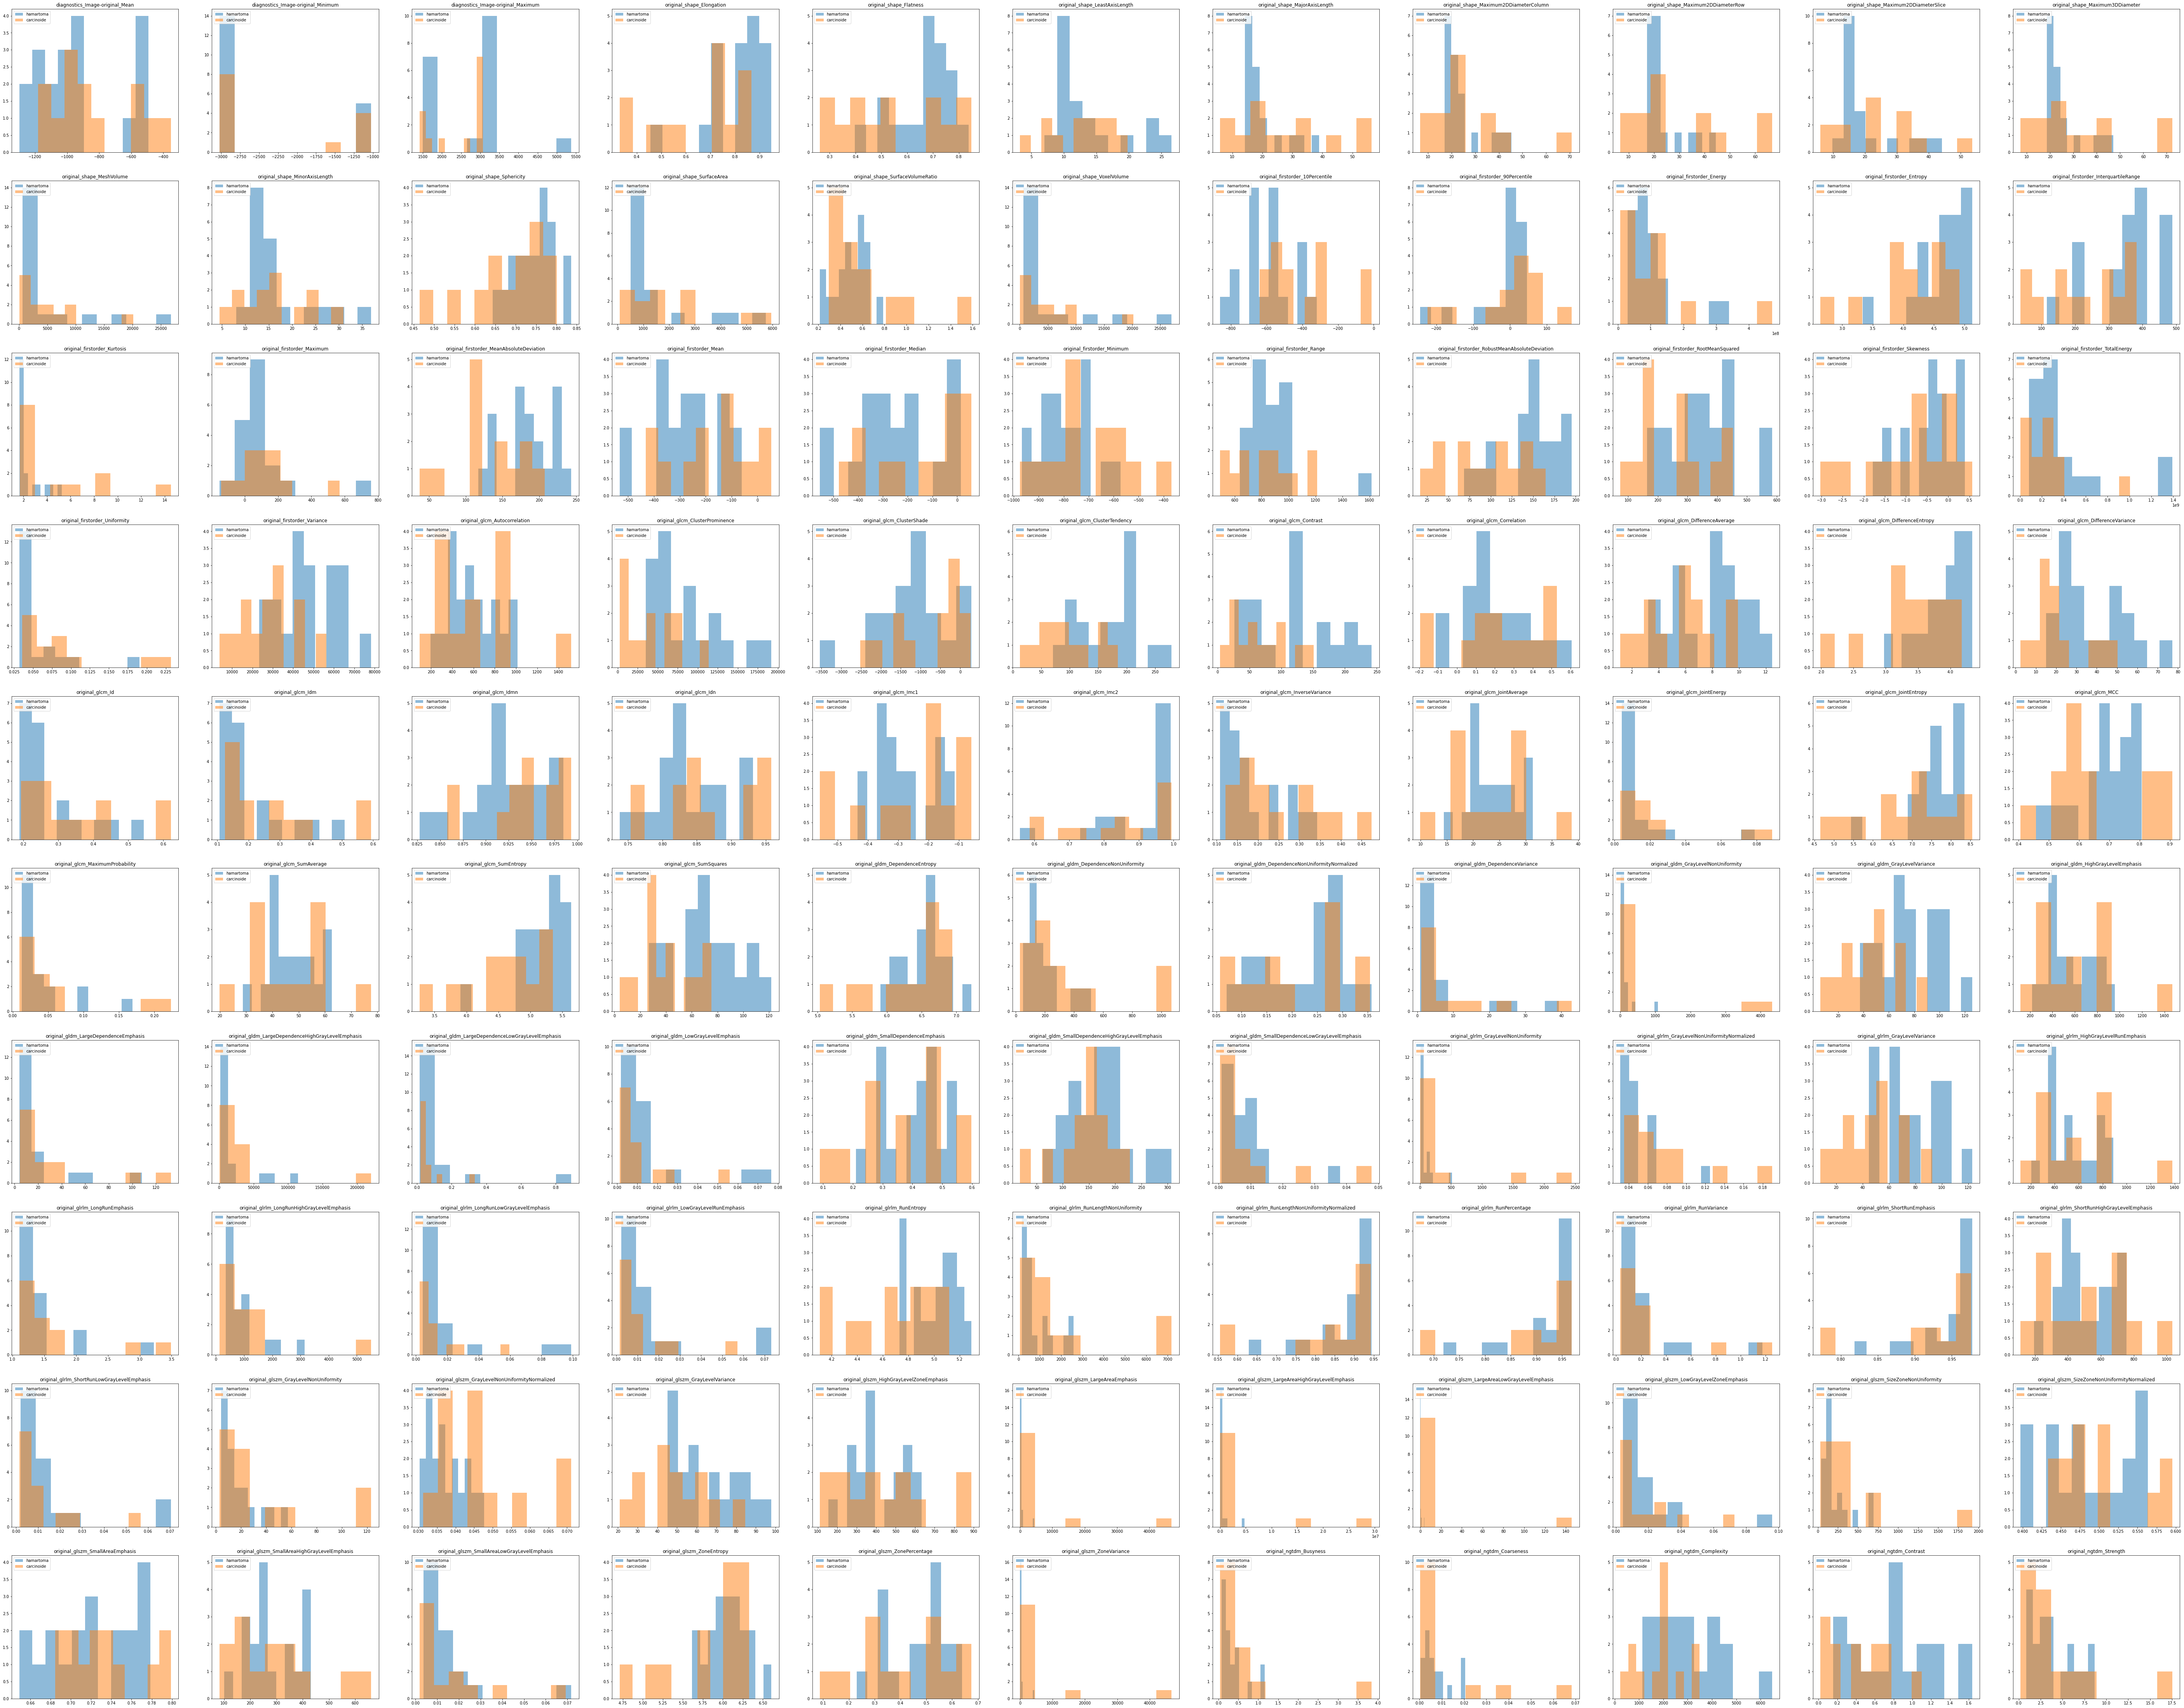

In [9]:
#VISUALIZAMOS LAS CARACTERISTICAS
ha=predata.iloc[0:19,:]
cr=predata.iloc[19:32,:]
count=1
plt.subplots(figsize=(100, 80))
for i in df.columns:
    plt.subplot(10,11,count)
    plt.hist(ha[i], alpha = 0.5, label='hamartoma')
    plt.hist(cr[i], alpha = 0.5, label='carcinoide')
    plt.legend(loc='upper left')
    plt.title(i) 
    count+=1

plt.savefig('drive/MyDrive/Carpeta TFG TEMPORAL/radiomic_features/histplot.png')

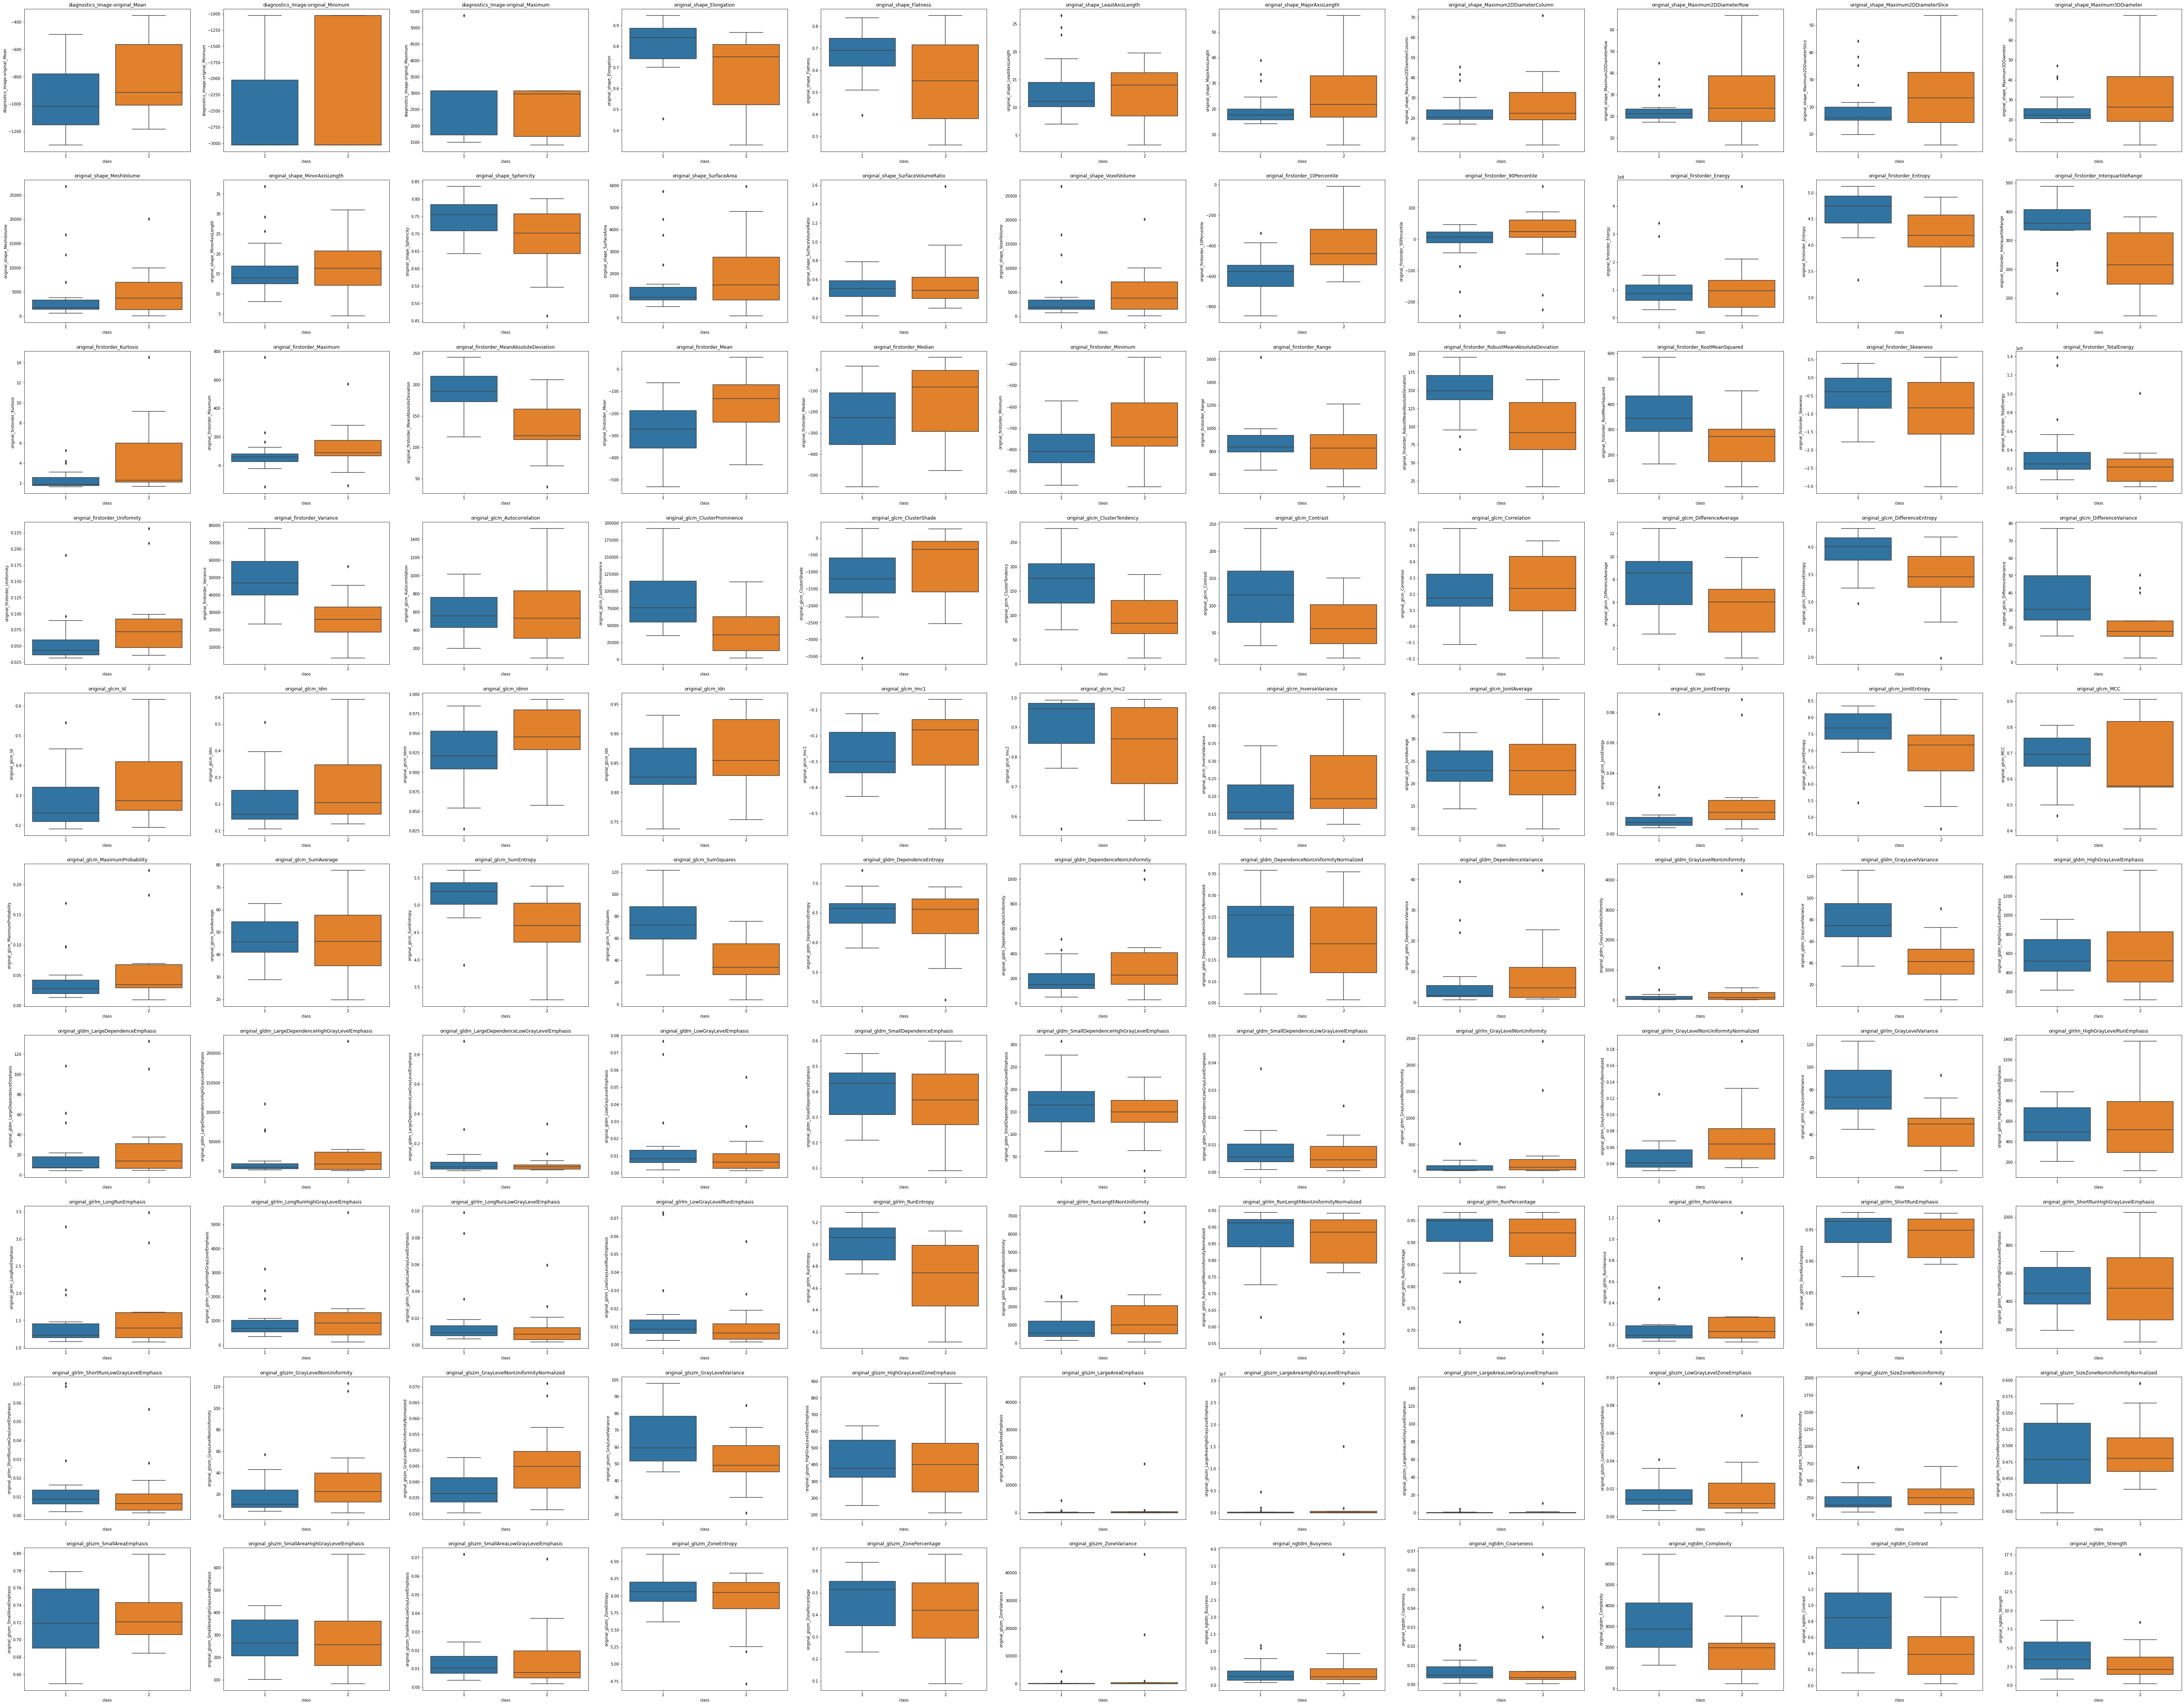

In [10]:
#otra visualizacion para ver outliers 
count=1
plt.subplots(figsize=(100, 80))
for i in df.columns:
    plt.subplot(10,11,count)
    sns.boxplot(data=predata, x="class", y=predata[i])
    plt.title(i) 
    count+=1

plt.savefig('drive/MyDrive/Carpeta TFG TEMPORAL/radiomic_features/boxplot.png')

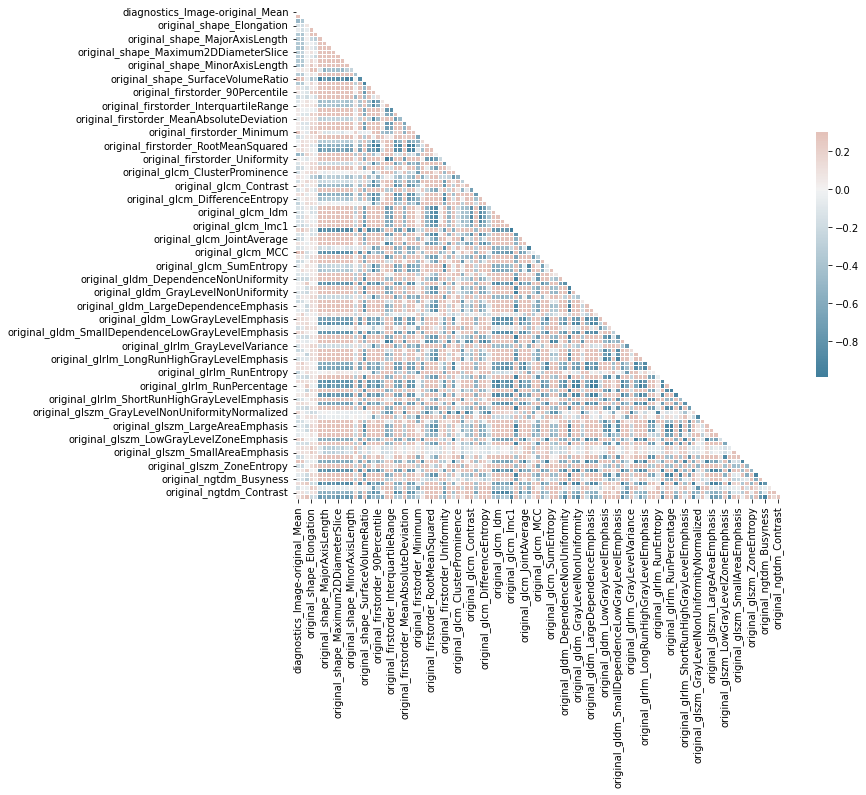

In [11]:
#cambiar entre corrN y corr en la mask y en el sns.heatmap
corrN= features_norm.corr(method='spearman')
corr= features_Scaled.corr(method='spearman')
mask= np.triu(np.ones_like(corr, dtype=bool))

fig,ax = plt.subplots(figsize=(11, 9))
cmap= sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr,
            mask=mask,
            cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=0.01, cbar_kws={'shrink': .5})

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


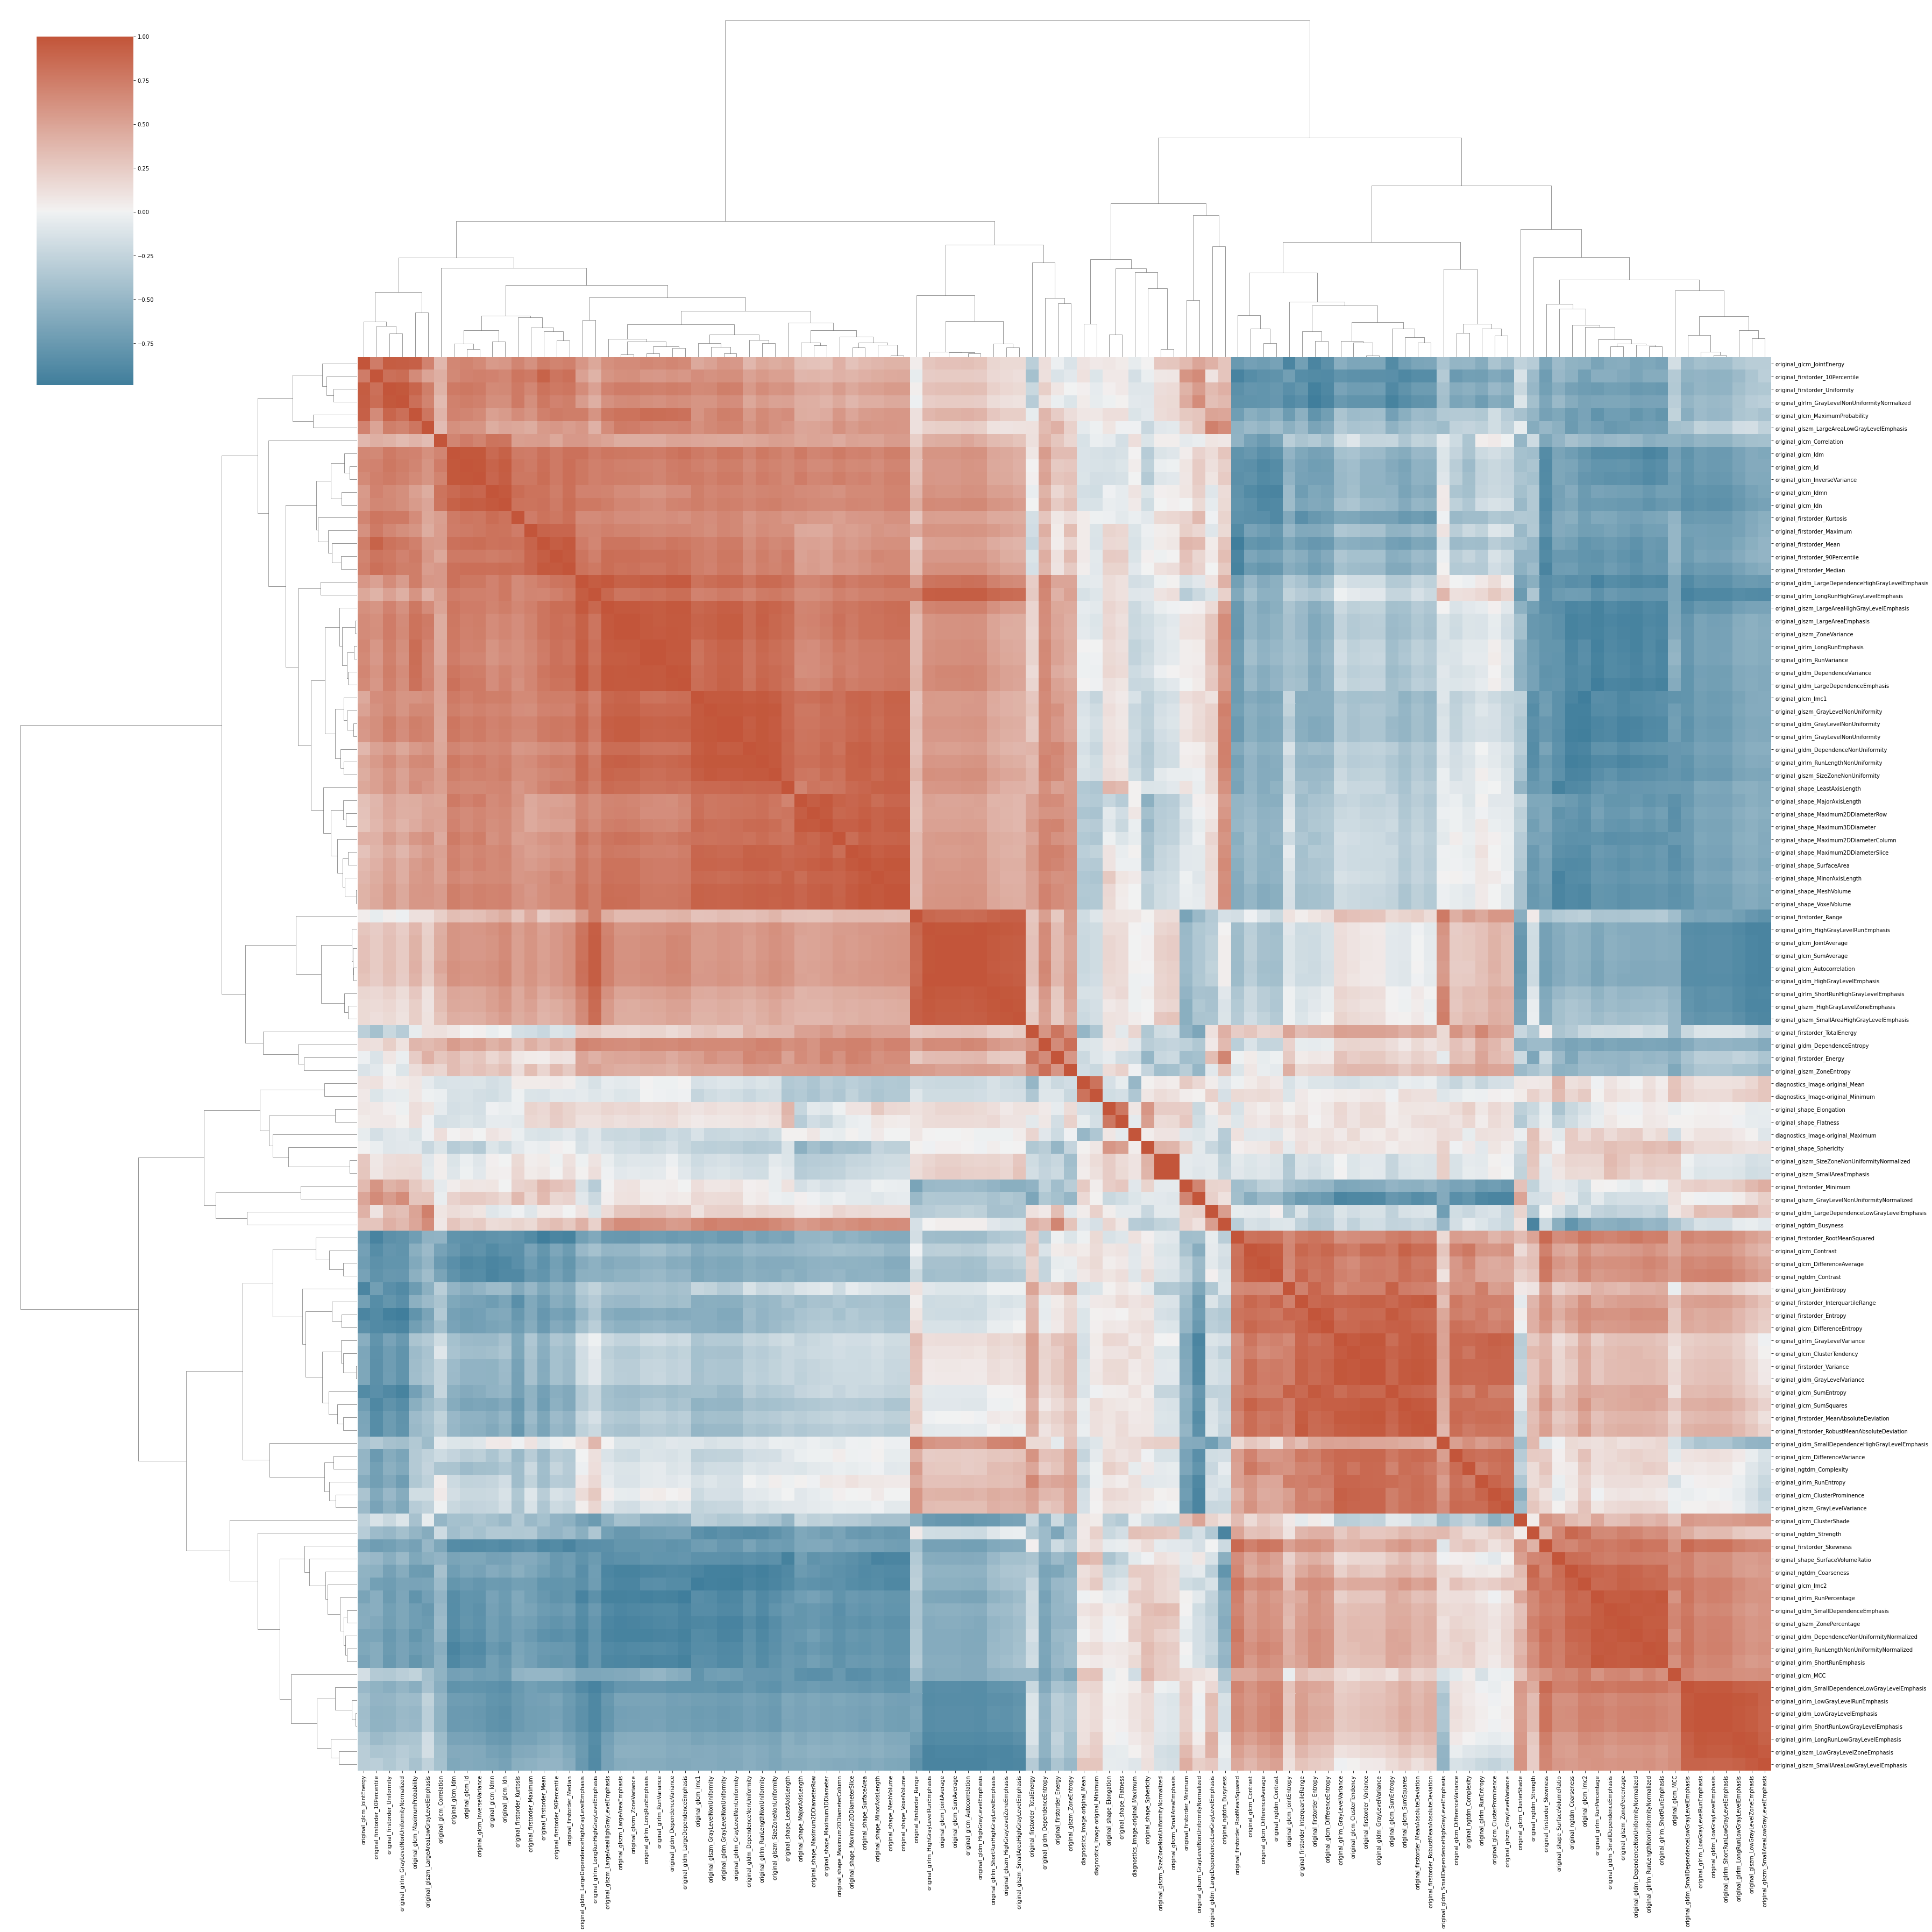

In [12]:
sns.clustermap(corr, figsize=(50, 50),
            cmap=cmap, square=True)
plt.savefig('drive/MyDrive/Carpeta TFG TEMPORAL/radiomic_features/dendogram.png')

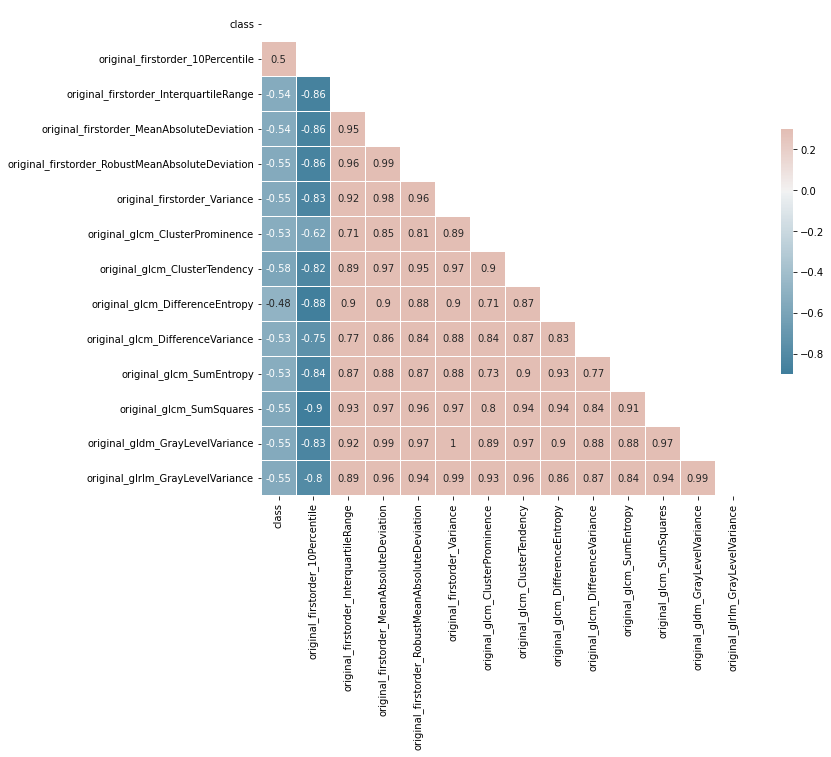

In [13]:
#correlacion de caracteristicas sifnificativas
corrN= data_SIGNIF.corr(method='spearman')
corr= data_SIGNIF.corr(method='spearman')
mask= np.triu(np.ones_like(corr, dtype=bool))

fig,ax = plt.subplots(figsize=(11, 9))
cmap= sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr,
            mask=mask,
            cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=0.01, cbar_kws={'shrink': .5})

In [14]:
paco = MultiCollinearityEliminator(data_SIGNIF,'class',0.9)
paco.autoEliminateMulticollinearity()

['original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_InterquartileRange', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_Variance', 'original_glcm_DifferenceEntropy', 'original_glcm_SumSquares', 'original_gldm_GrayLevelVariance', 'original_glcm_ClusterTendency', 'original_glrlm_GrayLevelVariance', 'original_glcm_ClusterProminence', 'original_glcm_SumEntropy'] 

                                                    class
original_glcm_DifferenceEntropy                  0.478949
original_firstorder_10Percentile                 0.503115
original_glcm_ClusterProminence                  0.527188
original_glcm_DifferenceVariance                 0.527188
original_glcm_SumEntropy                         0.527188
original_firstorder_InterquartileRange           0.540971
original_firstorder_MeanAbsoluteDeviation        0.540971
original_firstorder_RobustMeanAbsoluteDeviation  0.547862
original_firstorder_Variance                     0.547862
original_gldm_Gra

class  original_firstorder_10Percentile  original_glcm_ClusterTendency  \
0       1                            -381.5                     100.500622   
1       1                            -665.6                     214.619054   
2       1                            -661.8                     200.883840   
3       1                            -769.4                     159.584667   
4       1                            -770.7                     278.698076   
5       1                            -508.6                     157.650784   
6       1                            -553.0                     200.509153   
7       1                            -646.4                     213.513504   
8       1                            -671.0                     176.150680   
9       1                            -415.0                     100.153783   
10      1                            -569.0                     119.741567   
11      1                            -386.7                     109.286576   
12      1                            -549.4                     129.935914   
13      1                            -696.0                     184.401564   
14      1                            -318.1                      70.642359   
15      1                            -570.0                     205.575204   
16      1                            -625.5                     207.292192   
17      1                            -557.0                     146.269439   
18      1                            -860.4                     241.278660   
19      2                            -524.9                     158.339164   
20      2                            -266.0                      80.104793   
21      2                            -525.4                     184.112244   
22      2                            -293.3                      91.729058   
23      2                            -569.0                      52.492934   
24      2                            -453.0                      83.737669   
25      2                            -321.8                      62.426219   
26      2                            -497.4                     130.568884   
27      2                            -638.0                     109.569984   
28      2                            -341.9                      78.464205   
29      2                             -11.0                      12.720300   
30      2                             -43.0                      29.963686   
31      2                            -626.0                     150.699205   

    original_glcm_DifferenceVariance  
0                          21.742212  
1                          58.338128  
2                          28.179491  
3                          40.056011  
4                          77.200060  
5                          23.212079  
6                          29.882771  
7                          54.331240  
8                          50.521107  
9                          30.500223  
10                         20.123909  
11                         15.108448  
12                         24.131531  
13                         46.437819  
14                         24.310673  
15                         49.252637  
16                         38.730282  
17                         25.977355  
18                         61.812376  
19                         40.131457  
20                         18.554480  
21                         50.287023  
22                         23.800789  
23                         16.027512  
24                         11.666915  
25                         14.867164  
26                         16.056199  
27                         19.567293  
28                         17.680970  
29                          2.493574  
30                         12.480629  
31                         42.760468

In [15]:
paco = MultiCollinearityEliminator(data_all,'class',0.7)
paco.autoEliminateMulticollinearity()

['diagnostics_Image-original_Minimum', 'diagnostics_Image-original_Mean', 'original_shape_Flatness', 'original_shape_Elongation', 'original_shape_MajorAxisLength', 'original_shape_LeastAxisLength', 'original_shape_Maximum2DDiameterColumn', 'original_shape_Maximum2DDiameterRow', 'original_shape_Maximum2DDiameterSlice', 'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume', 'original_shape_MinorAxisLength', 'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio', 'original_shape_VoxelVolume', 'original_firstorder_90Percentile', 'original_firstorder_Median', 'original_firstorder_Skewness', 'original_glcm_Imc1', 'original_glcm_Imc2', 'original_glcm_MCC', 'original_gldm_DependenceNonUniformity', 'original_gldm_DependenceNonUniformityNormalized', 'original_gldm_DependenceVariance', 'original_gldm_GrayLevelNonUniformity', 'original_gldm_LargeDependenceEmphasis', 'original_gldm_LargeDependenceHighGrayLevelEmphasis', 'original_gldm_SmallDependenceEmphasis', 'original_gldm_Sm

class  diagnostics_Image-original_Mean  \
0       1                         0.356427   
1       1                         0.131292   
2       1                         0.224783   
3       1                         0.177418   
4       1                         0.823101   
5       1                         0.296759   
6       1                         0.261788   
7       1                         0.356993   
8       1                         0.000000   
9       1                         0.358642   
10      1                         0.852233   
11      1                         0.738254   
12      1                         0.282214   
13      1                         0.820197   
14      1                         0.095776   
15      1                         0.005347   
16      1                         0.846383   
17      1                         0.351303   
18      1                         0.119564   
19      2                         0.290785   
20      2                         0.307065   
21      2                         1.000000   
22      2                         0.122892   
23      2                         0.847603   
24      2                         0.356182   
25      2                         0.406989   
26      2                         0.804457   
27      2                         0.134349   
28      2                         0.405107   
29      2                         0.775830   
30      2                         0.311768   
31      2                         0.538417   

    diagnostics_Image-original_Maximum  original_shape_Elongation  \
0                             0.417571                   0.957693   
1                             0.417571                   0.815335   
2                             1.000000                   0.994578   
3                             0.417571                   0.203258   
4                             0.417066                   0.827737   
5                             0.417571                   0.845659   
6                             0.417571                   0.804819   
7                             0.043423                   0.644265   
8                             0.417571                   0.761344   
9                             0.076748                   0.937774   
10                            0.031810                   0.668351   
11                            0.077253                   0.663099   
12                            0.417571                   0.868204   
13                            0.078768                   0.893680   
14                            0.336279                   1.000000   
15                            0.417571                   0.879611   
16                            0.022217                   0.601880   
17                            0.020197                   0.907782   
18                            0.417571                   0.600189   
19                            0.000000                   0.776070   
20                            0.156526                   0.684920   
21                            0.417571                   0.815417   
22                            0.417571                   0.628534   
23                            0.417066                   0.678774   
24                            0.030800                   0.869089   
25                            0.417571                   0.233572   
26                            0.393587                   0.686452   
27                            0.417571                   0.000000   
28                            0.329210                   0.057261   
29                            0.035597                   0.431869   
30                            0.417571                   0.850535   
31                            0.064378                   0.308923   

    original_shape_Sphericity  original_firstorder_TotalEnergy  \
0                    0.737332                         0.191108   
1                    0.833547                         0.287267   
2        

In [16]:
data_nocorrSTD=paco.df   ######

In [17]:
juan = MultiCollinearityEliminator(data_norm,'class',0.7)
juan.autoEliminateMulticollinearity()

['diagnostics_Image-original_Minimum', 'diagnostics_Image-original_Mean', 'original_shape_Flatness', 'original_shape_Elongation', 'original_shape_MajorAxisLength', 'original_shape_LeastAxisLength', 'original_shape_Maximum2DDiameterColumn', 'original_shape_Maximum2DDiameterRow', 'original_shape_Maximum2DDiameterSlice', 'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume', 'original_shape_MinorAxisLength', 'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio', 'original_shape_VoxelVolume', 'original_firstorder_90Percentile', 'original_firstorder_Median', 'original_firstorder_Skewness', 'original_glcm_Imc1', 'original_glcm_Imc2', 'original_glcm_MCC', 'original_gldm_DependenceNonUniformity', 'original_gldm_DependenceNonUniformityNormalized', 'original_gldm_DependenceVariance', 'original_gldm_GrayLevelNonUniformity', 'original_gldm_LargeDependenceEmphasis', 'original_gldm_LargeDependenceHighGrayLevelEmphasis', 'original_gldm_SmallDependenceEmphasis', 'original_gldm_Sm

class  diagnostics_Image-original_Mean  \
0       1                        -0.217988   
1       1                        -1.005483   
2       1                        -0.678463   
3       1                        -0.844140   
4       1                         1.414377   
5       1                        -0.426699   
6       1                        -0.549025   
7       1                        -0.216009   
8       1                        -1.464725   
9       1                        -0.210242   
10      1                         1.516275   
11      1                         1.117593   
12      1                        -0.477576   
13      1                         1.404220   
14      1                        -1.129712   
15      1                        -1.446021   
16      1                         1.495813   
17      1                        -0.235911   
18      1                        -1.046505   
19      2                        -0.447595   
20      2                        -0.390651   
21      2                         2.033147   
22      2                        -1.034863   
23      2                         1.500080   
24      2                        -0.218846   
25      2                        -0.041130   
26      2                         1.349161   
27      2                        -0.994788   
28      2                        -0.047711   
29      2                         1.249030   
30      2                        -0.374202   
31      2                         0.418589   

    diagnostics_Image-original_Maximum  original_shape_Elongation  \
0                             0.580999                   1.044628   
1                             0.580999                   0.500741   
2                             3.298067                   1.185549   
3                             0.580999                  -1.837744   
4                             0.578643                   0.548121   
5                             0.580999                   0.616592   
6                             0.580999                   0.460560   
7                            -1.164426                  -0.152846   
8                             0.580999                   0.294462   
9                            -1.008963                   0.968526   
10                           -1.218603                  -0.060824   
11                           -1.006608                  -0.080888   
12                            0.580999                   0.702729   
13                           -0.999541                   0.800061   
14                            0.201763                   1.206264   
15                            0.580999                   0.746310   
16                           -1.263357                  -0.314780   
17                           -1.272779                   0.853937   
18                            0.580999                  -0.321242   
19                           -1.366999                   0.350723   
20                           -0.636795                   0.002480   
21                            0.580999                   0.501053   
22                            0.580999                  -0.212947   
23                            0.578643                  -0.021001   
24                           -1.223314                   0.706110   
25                            0.580999                  -1.721927   
26                            0.469112                   0.008332   
27                            0.580999                  -2.614304   
28                            0.168786                  -2.395536   
29                           -1.200937                  -0.964317   
30                            0.580999                   0.635222   
31                           -1.066673                  -1.434042   

    original_shape_Sphericity  original_firstorder_TotalEnergy  \
0                    0.194824                        -0.181630   
1                    0.643074                         0.223572   
2        

In [18]:
data_nocorrNORM=juan.df     ######

In [19]:
jose = MultiCollinearityEliminator(data_IMGNORM,'class',0.7)
jose.autoEliminateMulticollinearity()

['diagnostics_Image-original_Minimum', 'diagnostics_Image-original_Mean', 'original_firstorder_Entropy', 'original_firstorder_Minimum', 'original_firstorder_Uniformity', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_Correlation', 'original_glcm_DifferenceAverage', 'original_glcm_DifferenceEntropy', 'original_glcm_DifferenceVariance', 'original_glcm_Id', 'original_glcm_Idm', 'original_glcm_Idmn', 'original_glcm_Idn', 'original_glcm_Imc1', 'original_glcm_Imc2', 'original_glcm_InverseVariance', 'original_glcm_JointAverage', 'original_glcm_JointEnergy', 'original_glcm_JointEntropy', 'original_glcm_MCC', 'original_glcm_MaximumProbability', 'original_glcm_SumAverage', 'original_glcm_SumEntropy', 'original_glcm_SumSquares', 'original_gldm_GrayLevelVariance', 'original_gldm_HighGrayLevelEmphasis', 'original_gldm_LowGrayLevelEmphasis', 'original_glrlm_GrayLevelNonUniform

class  diagnostics_Image-original_Mean  \
0       1                         0.356427   
1       1                         0.131292   
2       1                         0.224783   
3       1                         0.177418   
4       1                         0.823101   
5       1                         0.296759   
6       1                         0.261788   
7       1                         0.356993   
8       1                         0.000000   
9       1                         0.358642   
10      1                         0.852233   
11      1                         0.738254   
12      1                         0.282214   
13      1                         0.820197   
14      1                         0.095776   
15      1                         0.005347   
16      1                         0.846383   
17      1                         0.351303   
18      1                         0.119564   
19      2                         0.290785   
20      2                         0.307065   
21      2                         1.000000   
22      2                         0.122892   
23      2                         0.847603   
24      2                         0.356182   
25      2                         0.406989   
26      2                         0.804457   
27      2                         0.134349   
28      2                         0.405107   
29      2                         0.775830   
30      2                         0.311768   
31      2                         0.538417   

    diagnostics_Image-original_Maximum  original_shape_Elongation  \
0                             0.417571                   0.957693   
1                             0.417571                   0.815335   
2                             1.000000                   0.994578   
3                             0.417571                   0.203258   
4                             0.417066                   0.827737   
5                             0.417571                   0.845659   
6                             0.417571                   0.804819   
7                             0.043423                   0.644265   
8                             0.417571                   0.761344   
9                             0.076748                   0.937774   
10                            0.031810                   0.668351   
11                            0.077253                   0.663099   
12                            0.417571                   0.868204   
13                            0.078768                   0.893680   
14                            0.336279                   1.000000   
15                            0.417571                   0.879611   
16                            0.022217                   0.601880   
17                            0.020197                   0.907782   
18                            0.417571                   0.600189   
19                            0.000000                   0.776070   
20                            0.156526                   0.684920   
21                            0.417571                   0.815417   
22                            0.417571                   0.628534   
23                            0.417066                   0.678774   
24                            0.030800                   0.869089   
25                            0.417571                   0.233572   
26                            0.393587                   0.686452   
27                            0.417571                   0.000000   
28                            0.329210                   0.057261   
29                            0.035597                   0.431869   
30                            0.417571                   0.850535   
31                            0.064378                   0.308923   

    original_shape_Sphericity  original_firstorder_90Percentile  \
0                    0.737332                          0.379052   
1                    0.833547                          0.720163   
2     

In [20]:
data_nocorrIMGNORM=jose.df   ######

In [21]:
pepe = MultiCollinearityEliminator(predata,'class',0.7)
pepe.autoEliminateMulticollinearity()

['diagnostics_Image-original_Minimum', 'diagnostics_Image-original_Mean', 'original_shape_Flatness', 'original_shape_Elongation', 'original_shape_MajorAxisLength', 'original_shape_LeastAxisLength', 'original_shape_Maximum2DDiameterColumn', 'original_shape_Maximum2DDiameterRow', 'original_shape_Maximum2DDiameterSlice', 'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume', 'original_shape_MinorAxisLength', 'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio', 'original_shape_VoxelVolume', 'original_firstorder_90Percentile', 'original_firstorder_Median', 'original_firstorder_Skewness', 'original_glcm_Imc1', 'original_glcm_Imc2', 'original_glcm_MCC', 'original_gldm_DependenceNonUniformity', 'original_gldm_DependenceNonUniformityNormalized', 'original_gldm_DependenceVariance', 'original_gldm_GrayLevelNonUniformity', 'original_gldm_LargeDependenceEmphasis', 'original_gldm_LargeDependenceHighGrayLevelEmphasis', 'original_gldm_SmallDependenceEmphasis', 'original_gldm_Sm

class  diagnostics_Image-original_Mean  \
0       1                      -960.878198   
1       1                     -1173.543463   
2       1                     -1085.230962   
3       1                     -1129.972399   
4       1                      -520.053509   
5       1                     -1017.241280   
6       1                     -1050.275740   
7       1                      -960.343989   
8       1                     -1297.563113   
9       1                      -958.786372   
10      1                      -492.535594   
11      1                      -600.200854   
12      1                     -1030.980873   
13      1                      -522.796423   
14      1                     -1207.092095   
15      1                     -1292.512025   
16      1                      -498.061512   
17      1                      -965.718337   
18      1                     -1184.621740   
19      2                     -1022.884334   
20      2                     -1007.506558   
21      2                      -352.952909   
22      2                     -1181.477678   
23      2                      -496.909074   
24      2                      -961.110075   
25      2                      -913.117276   
26      2                      -537.665094   
27      2                     -1170.655306   
28      2                      -914.894454   
29      2                      -564.705855   
30      2                     -1003.064213   
31      2                      -788.968827   

    diagnostics_Image-original_Maximum  original_shape_Elongation  \
0                               3071.0                   0.921655   
1                               3071.0                   0.833863   
2                               5378.0                   0.944402   
3                               3071.0                   0.456394   
4                               3069.0                   0.841511   
5                               3071.0                   0.852563   
6                               3071.0                   0.827377   
7                               1589.0                   0.728364   
8                               3071.0                   0.800566   
9                               1721.0                   0.909371   
10                              1543.0                   0.743217   
11                              1723.0                   0.739979   
12                              3071.0                   0.866467   
13                              1729.0                   0.882178   
14                              2749.0                   0.947746   
15                              3071.0                   0.873502   
16                              1505.0                   0.702225   
17                              1497.0                   0.890875   
18                              3071.0                   0.701182   
19                              1417.0                   0.809648   
20                              2037.0                   0.753436   
21                              3071.0                   0.833914   
22                              3071.0                   0.718662   
23                              3069.0                   0.749646   
24                              1539.0                   0.867013   
25                              3071.0                   0.475089   
26                              2976.0                   0.754380   
27                              3071.0                   0.331044   
28                              2721.0                   0.366357   
29                              1558.0                   0.597379   
30                              3071.0                   0.855571   
31                              1672.0                   0.521558   

    original_shape_Sphericity  original_firstorder_TotalEnergy  \
0                    0.738616                     2.698061e+08   
1                    0.774399                     4.029836e+08   
2        

In [22]:
data_nocorr=pepe.df   ######

# checkpoint1:
la segunda vez iniciar a correrlo desde aqui

In [309]:
#cambiar data_nocorr por: data_nocorrNORM o data_nocorrIMGNORM data_nocorrSTD
#predata o data_all o data_norm o data_IMGNORM 
#data_SIGNIF O data_SIGNIFSTD o data_SIGNIFNORM o data_SIGNIFIMGNORM 
X = data_SIGNIF.drop(['class'],axis=1)
y = predata['class']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.18, random_state=5)

In [310]:
# Compruebo que haya representatividad de todas las clases en el train y en el test
print(sum(y_train==1),sum(y_train==2),sum(y_test==1),sum(y_test==2))

14 12 5 1


In [312]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

ypred_train = classifier.predict(X_train)
y_pred = classifier.predict(X_test)
print(accuracy_score(y_train,ypred_train))
print(accuracy_score(y_test, y_pred))

0.8076923076923077
0.5


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [313]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(classifier, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.583 (0.401)


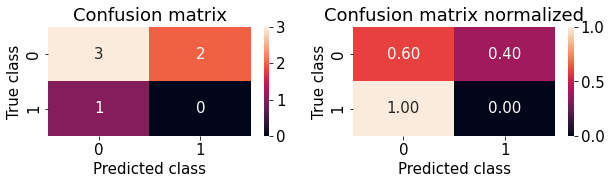

              precision    recall  f1-score   support

           1       0.75      0.60      0.67         5
           2       0.00      0.00      0.00         1

    accuracy                           0.50         6
   macro avg       0.38      0.30      0.33         6
weighted avg       0.62      0.50      0.56         6

                                  0     1  micro-average
accuracy                   0.500000  0.50            0.5
precision                  0.750000  0.00            0.5
sensitivity                0.600000  0.00            0.5
specificity                0.000000  0.60            0.5
negative_predictive_value  0.000000  0.75            0.5
positive_predictive_value  0.750000  0.00            0.5
f1                         0.666667   NaN            0.5


In [314]:
conf_matrix(y_test, y_pred)

Test Area under Curve = 0.6
Train Area under Curve = 0.8630952380952381


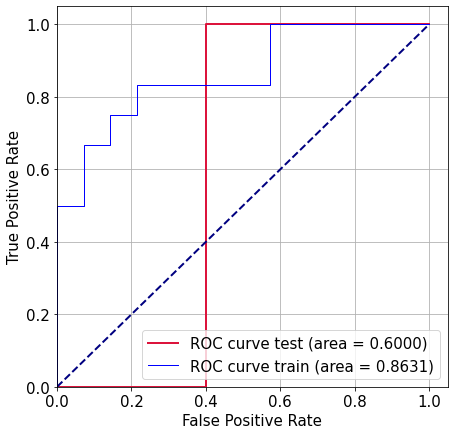

In [315]:
roc_auc_curve(X,X_train,X_test)

In [316]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
classifier = DecisionTreeClassifier(criterion='gini', max_depth=1, min_samples_split=2)
classifier.fit(X_train, y_train)
ypred_train = classifier.predict(X_train)
y_pred = classifier.predict(X_test)
print(accuracy_score(y_train,ypred_train))
print(accuracy_score(y_test, y_pred))

0.8076923076923077
0.8333333333333334


In [317]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(classifier, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.692 (0.321)


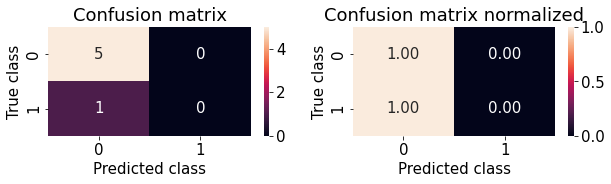

              precision    recall  f1-score   support

           1       0.83      1.00      0.91         5
           2       0.00      0.00      0.00         1

    accuracy                           0.83         6
   macro avg       0.42      0.50      0.45         6
weighted avg       0.69      0.83      0.76         6

                                  0         1  micro-average
accuracy                   0.833333  0.833333       0.833333
precision                  0.833333       NaN       0.833333
sensitivity                1.000000  0.000000       0.833333
specificity                0.000000  1.000000       0.833333
negative_predictive_value       NaN  0.833333       0.833333
positive_predictive_value  0.833333       NaN       0.833333
f1                         0.909091       NaN       0.833333


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [318]:
conf_matrix(y_test, y_pred)

Test Area under Curve = 0.5
Train Area under Curve = 0.7976190476190476


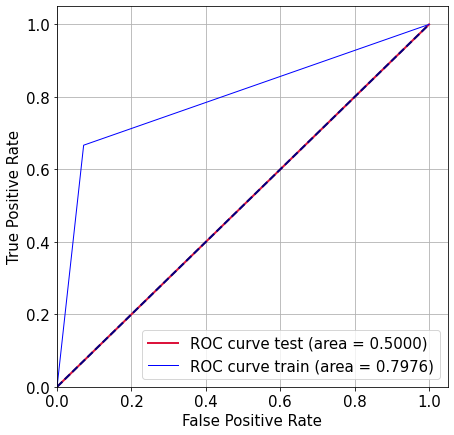

In [319]:
roc_auc_curve(X,X_train,X_test)

In [320]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
classifier = SVC(kernel='rbf', gamma=0.4, probability=True)
classifier.fit(X_train, y_train)
ypred_train = classifier.predict(X_train)
y_pred = classifier.predict(X_test)
print(accuracy_score(y_train,ypred_train))
print(accuracy_score(y_test, y_pred))

1.0
0.8333333333333334


In [321]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(classifier, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.608 (0.247)


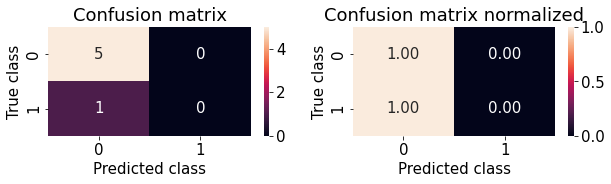

              precision    recall  f1-score   support

           1       0.83      1.00      0.91         5
           2       0.00      0.00      0.00         1

    accuracy                           0.83         6
   macro avg       0.42      0.50      0.45         6
weighted avg       0.69      0.83      0.76         6

                                  0         1  micro-average
accuracy                   0.833333  0.833333       0.833333
precision                  0.833333       NaN       0.833333
sensitivity                1.000000  0.000000       0.833333
specificity                0.000000  1.000000       0.833333
negative_predictive_value       NaN  0.833333       0.833333
positive_predictive_value  0.833333       NaN       0.833333
f1                         0.909091       NaN       0.833333


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [322]:
conf_matrix(y_test, y_pred)

Test Area under Curve = 0.5
Train Area under Curve = 0.0


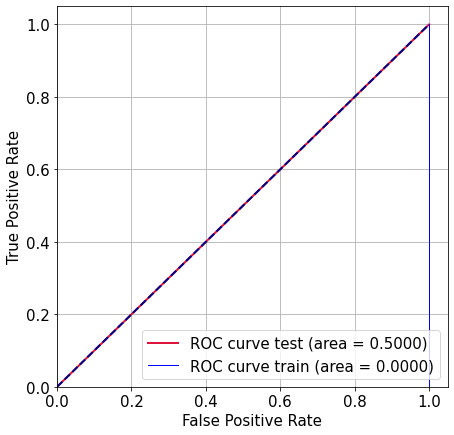

In [323]:
roc_auc_curve(X,X_train,X_test)

In [324]:
break #un error para parar de correr el codigo

SyntaxError: ignored

# checkpoint2

Parte con PCAs

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
DatosPCA=pca.fit_transform(data_all.drop('class', axis=1))
DatosPCA = pd.DataFrame(data = DatosPCA)

In [ ]:
#VER COMO DECORRELACIONAN LOS PCA
corr= data_all.corr(method='spearman')
corr2= DatosPCA.corr(method='spearman')
mask= np.triu(np.ones_like(corr, dtype=bool))
cmap= sns.diverging_palette(230, 20, as_cmap=True)

plt.figure(figsize=[6,12])
plt.subplot(211)
sns.heatmap(corr,
            #mask=mask, 
            cmap=cmap, vmax=.3, center=0, xticklabels=False, yticklabels=False, cbar=False,
            square=True)
plt.subplot(212)
sns.heatmap(corr2,
            #mask=mask, 
            cmap=cmap, vmax=.3, center=0, xticklabels=False, yticklabels=False, cbar=False,
            square=True)

In [ ]:
#Cambiar entre predata o data_all o data_norm o data_IMGNORM
from sklearn.decomposition import PCA
pca = PCA().fit(predata.drop('class', axis=1))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.axhline(y=0.90, color='r', linestyle='-')
plt.axvline(x=7, color='r', linestyle='-')
#con la normalizacion en la imagen con 7 PCA se consigue el 95% de la varianza

In [ ]:
#Cambiar entre predata o data_all o data_norm o data_IMGNORM
from sklearn.decomposition import PCA
pca = PCA(n_components = 7)
DatosPCA=pca.fit_transform(predata.drop('class', axis=1))
DatosPCA = pd.DataFrame(data = DatosPCA, columns = ['pca 1', 'pca 2', 'pca 3','pca 4', 'pca 5', 'pca 6', 'pca 7'])
DatosPCA=pd.concat([label,DatosPCA],axis=1)

In [ ]:
X = DatosPCA.drop(['class'],axis=1)
y = DatosPCA['class']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.18, random_state=5)

In [ ]:
# Compruebo que haya representatividad de todas las clases en el train y en el test
print(sum(y_train==1),sum(y_train==2),sum(y_test==1),sum(y_test==2))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
classifier = LogisticRegression(solver='lbfgs')
classifier.fit(X_train, y_train)

ypred_train = classifier.predict(X_train)
y_pred = classifier.predict(X_test)
print(accuracy_score(y_train,ypred_train))
print(accuracy_score(y_test, y_pred))

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(classifier, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

In [ ]:
conf_matrix(y_test, y_pred)

In [ ]:
roc_auc_curve(X,X_train,X_test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
classifier = DecisionTreeClassifier(criterion= 'gini', max_depth= 1, min_samples_split=2)
classifier.fit(X_train, y_train)
ypred_train = classifier.predict(X_train)
y_pred = classifier.predict(X_test)
print(accuracy_score(y_train,ypred_train))
print(accuracy_score(y_test, y_pred))

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(classifier, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

In [ ]:
conf_matrix(y_test, y_pred)

In [ ]:
roc_auc_curve(X,X_train,X_test)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
classifier = SVC(kernel='rbf', gamma=0.4, probability=True)
classifier.fit(X_train, y_train)
ypred_train = classifier.predict(X_train)
y_pred = classifier.predict(X_test)
print(accuracy_score(y_train,ypred_train))
print(accuracy_score(y_test, y_pred))

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(classifier, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

In [ ]:
conf_matrix(y_test, y_pred)

In [ ]:
roc_auc_curve(X,X_train,X_test)

In [ ]:
break #un error para parar de correr el codigo

# SEGUNDA PARTE TRABAJO: COMPRENDER LOS MODELOS VALIDOS


*   DATOS NORMALIZADOS EN IMG: logistic reg con no corr 
*   DATOS CON CARACT NORMALIZADAS: arbol decision no correlac
*   DATOS SIN estandarizados: arbol decision no correlac
*   DATOS SIN tratamiento: arbol decision no correlac






Para ello pintamos los arboles de decision y miramos cual es el ranking de variables utilizadas en la Logic regresion





In [ ]:
#comparamos variables significativas con variables no correlacionadas de datos standar con var normalizadas de un metodo u otro

print(data_SIGNIF.columns.tolist())
print(data_nocorr.columns.tolist())
print(data_nocorrNORM.columns.tolist())
#los normalizados con la imagen
print(['class','original_firstorder_90Percentile', 'original_firstorder_Kurtosis', 'original_firstorder_MeanAbsoluteDeviation', 'original_gldm_DependenceVariance', 'original_glrlm_GrayLevelNonUniformity', 'original_glrlm_RunLengthNonUniformity', 'original_glszm_SizeZoneNonUniformity', 'original_glszm_ZoneVariance'])

# 1-RANKING DE TREE CLASSIFIER

In [356]:
#tienes data_all para todas, data_normScaled para normaliz, data_nocorr para no correlac,
#data_SIGNIF para significativas, data_nocorrNORM
#dado que no hay ningun modelo relevante en las normalizadas en img no hay que cambiar de archivo

from sklearn.tree import DecisionTreeClassifier
X = data_nocorr.drop(['class'],axis=1)  
y = data_nocorr['class']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.18, random_state=5)

cols=X.columns.tolist()

model=DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=2)
model.fit(X_train, y_train)

feature_importances = pd.DataFrame(model.feature_importances_,index = X[cols].columns,columns=['importance']).sort_values('importance',ascending=False)                                                            
feature_importances

importance
original_glcm_ClusterTendency                         0.389045
original_firstorder_TotalEnergy                       0.262113
original_shape_Sphericity                             0.205135
diagnostics_Image-original_Mean                       0.143707
diagnostics_Image-original_Maximum                    0.000000
original_shape_Elongation                             0.000000
original_glcm_ClusterShade                            0.000000
original_gldm_SmallDependenceHighGrayLevelEmphasis    0.000000
original_glszm_SizeZoneNonUniformityNormalized        0.000000
original_glszm_ZoneEntropy                            0.000000

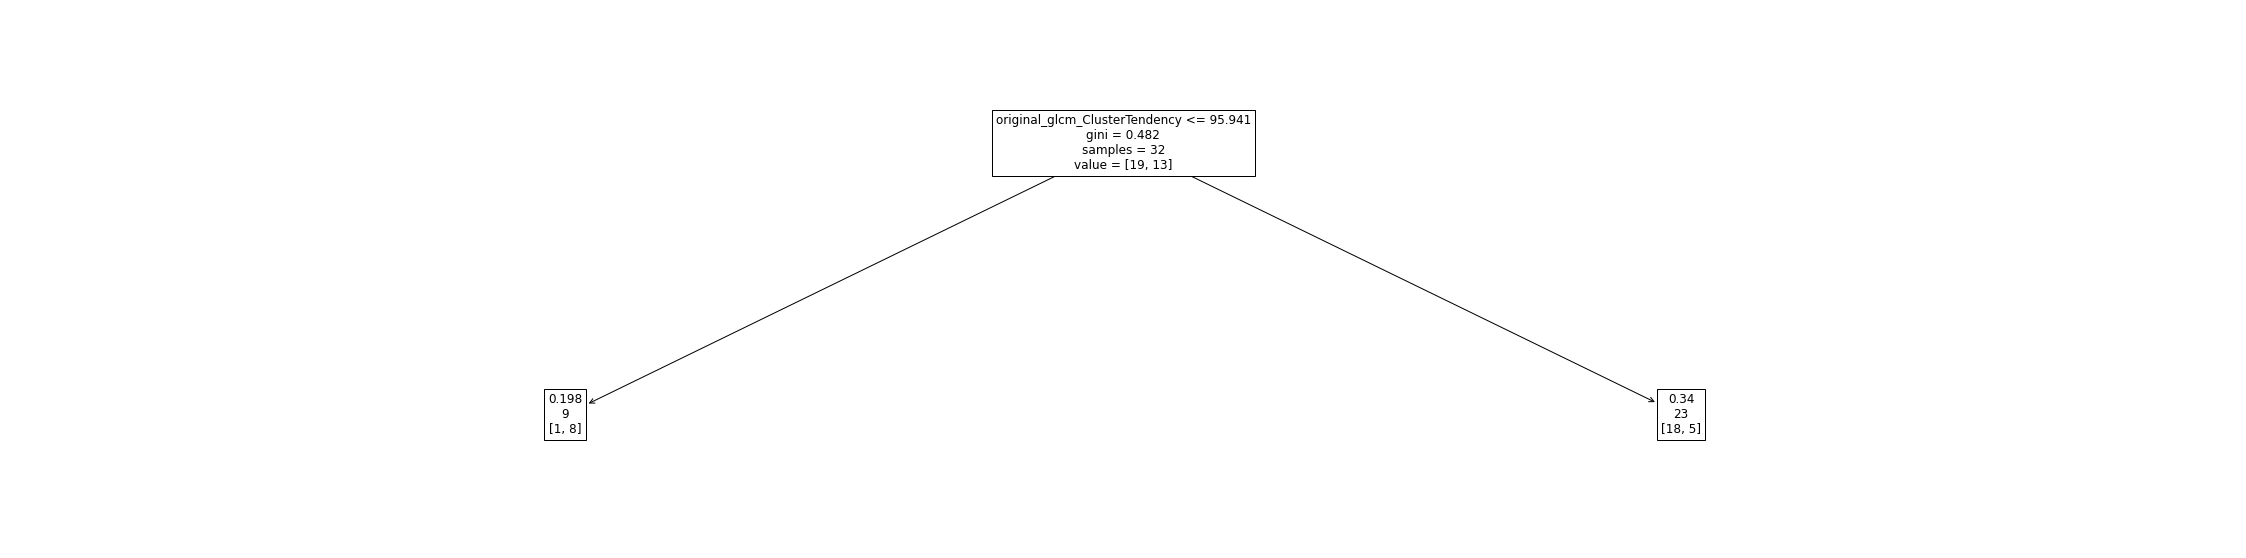

In [348]:
from sklearn.tree import plot_tree
dtree2 = DecisionTreeClassifier(criterion='gini', max_depth=1, min_samples_split=2)
dtree2.fit(X, y)
cols=X.columns.tolist()
plt.figure(figsize=(40,10))
plot_tree(dtree2, max_depth=1,feature_names=cols,label='root',fontsize=12)
plt.show()

Todas, Significativas--> original_glcm_DifferenceVariance
No_corr --> original_glcm_ClusterTendency (no hay ant)
No_corr con normalizacion --> original_glszm_ZoneVariance

*   Todas, Significativas--> original_glcm_DifferenceVariance
*   No_corr --> original_glcm_ClusterTendency (no hay ant)

Captura de pantalla 2022-03-09 a las 20.14.58.png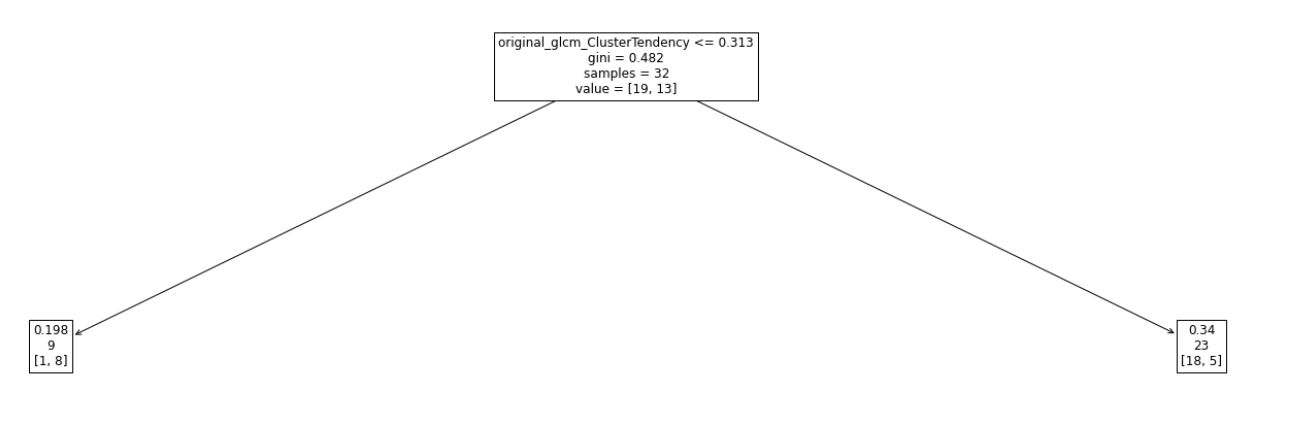



**COMPROBAMOS LA CORRELACION CON OTRAS CARACTERISTICAS**
***original_glcm_DifferenceVariance***

In [ ]:
#averiguar cuales estan correlacionadas y juntarlas con este codigo para ver a cuales se parece mucho
original_glcm_DifferenceVariance=corr.iloc[43:44,:] 

In [ ]:
(abs(original_glcm_DifferenceVariance)>0.7)

In [ ]:
upper = original_glcm_DifferenceVariance.where(np.triu(np.ones(original_glcm_DifferenceVariance.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.7 pero no coge ni la primera ni la ultima original_firstorder_10Percentile
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

In [ ]:
to_drop=['original_firstorder_10Percentile','original_firstorder_MeanAbsoluteDeviation',
 'original_firstorder_RobustMeanAbsoluteDeviation',
 'original_firstorder_Variance',
 'original_glcm_ClusterProminence',
 'original_glcm_ClusterTendency',
 'original_glcm_DifferenceEntropy',
 'original_glcm_DifferenceVariance',
 'original_glcm_SumSquares',
 'original_gldm_GrayLevelVariance',
 'original_glrlm_GrayLevelVariance',
 'original_glrlm_RunEntropy',
 'original_glszm_GrayLevelVariance',
 'original_ngtdm_Complexity']

In [ ]:
prueba=data_all.drop(to_drop, axis=1)
a=prueba.columns.tolist()
prueba2=data_all.drop(a, axis=1)
prueba2=pd.concat([label,prueba2],axis=1)

In [ ]:
corr2= prueba2.corr(method='spearman')
mask= np.triu(np.ones_like(corr2, dtype=bool))

fig,ax = plt.subplots(figsize=(20, 13))
cmap= sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr2, annot=True,
            mask=mask,
            cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=0.01, cbar_kws={'shrink': .5})

Aqui se puede ver como original_glcm_DifferenceVariance esta muy correlacionada con el resto pero nunca supera el 0.9 de correlacion. Con nuestro criterio para escoger al estar tan correlac con original_glcm_ClusterTendency se cogio esta perdiendo informacion. Esto plantea cambiar el corte o el criterio para tirar las variables

**COMPROBAMOS LA CORRELACION CON OTRAS CARACTERISTICAS**
***original_glszm_ZoneVariance***

In [ ]:
#averiguar cuales estan correlacionadas y juntarlas con este codigo para ver a cuales se parece mucho
original_glszm_ZoneVariance=corrN.iloc[104:105,:] 

In [ ]:
(abs(original_glszm_ZoneVariance)>0.7)

In [ ]:
upper = original_glszm_ZoneVariance.where(np.triu(np.ones(original_glszm_ZoneVariance.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.7 pero no coge ni la primera ni la ultima 
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

In [ ]:
to_drop

In [ ]:
prueba=data_normScaled.drop(to_drop, axis=1)
a=prueba.columns.tolist()
prueba2=data_normScaled.drop(a, axis=1)
prueba2=pd.concat([label,prueba2],axis=1)

In [ ]:
corr3= prueba2.corr(method='spearman')
mask= np.triu(np.ones_like(corr3, dtype=bool))

fig,ax = plt.subplots(figsize=(20, 13))
cmap= sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr3, annot=True,
            mask=mask,
            cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=0.01, cbar_kws={'shrink': .5})

original_glszm_ZoneVariance presenta mucha correlacion con las distintas variables. De hecho es igual (Corr=1) que original_glszm_LargeAreaEmphasis y casi identica (Corr=0.99) original_glszm_LargeAreaHighGrayLevelEmphasis. Por esto van alternando entre esas caracteristicas (la primera y principal que son identicas). El resto no estan tan correlacionadas.



# 2-COMPROBAR RANKING DE VARIABLES EN LOGIC REGRESION
DATOS NORMALIZADOS EN IMG: logistic reg con no corr
DATOS solo estandarizados con caract no correlacionada

In [325]:
!pip install mlxtend
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

In [337]:
# importing the models
lreg = LogisticRegression(solver='lbfgs')
sfs1 = sfs(lreg, k_features=9, forward=True, verbose=2, scoring='neg_mean_squared_error') #k es el n de features. Para sacar ranking hacer uno a uno

#aqui poner o data_IMGNORM o data_nocorrIMGNORM o data_norm o data_nocorrNORM
from sklearn.utils import shuffle
data_shuffle= shuffle(data_nocorrIMGNORM, random_state=5) 

X = data_shuffle.drop(['class'],axis=1)
y = data_shuffle['class']
sfs1 = sfs1.fit(X, y)

feat_names = list(sfs1.k_feature_names_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.4s finished

[2022-03-25 22:15:29] Features: 1/9 -- score: -0.3380952380952381[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.4s finished

[2022-03-25 22:15:29] Features: 2/9 -- score: -0.3095238095238095[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished

[2022-03-25 22:15:30] Features: 3/9 -- score: -0.28095238095238095[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 

In [327]:
#para sacar el ranking ir haciendo una a una
print(feat_names)

['original_shape_Elongation', 'original_shape_Sphericity', 'original_glcm_ClusterTendency']


In [338]:
#comprobamos que sea asi con estas
todrop=['diagnostics_Image-original_Mean', 'diagnostics_Image-original_Maximum', 'original_shape_Elongation',  #9 mejores SWS IMGNorm
        'original_shape_Sphericity', 'original_firstorder_Kurtosis', 'original_gldm_DependenceVariance',
        'original_glrlm_GrayLevelNonUniformity', 'original_glrlm_RunLengthNonUniformity', 'original_glszm_SizeZoneNonUniformity']

#aqui poner o data_IMGNORM o data_nocorrIMGNORM como en celda anterior
prueba=data_nocorrIMGNORM.drop(feat_names, axis=1)
a=prueba.columns.tolist()
prueba2=data_nocorrIMGNORM.drop(a, axis=1)
prueba2=pd.concat([label,prueba2],axis=1)

from sklearn.tree import DecisionTreeClassifier
X = prueba2.drop(['class'],axis=1)  
y = prueba2['class']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.18, random_state=5)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

ypred_train = classifier.predict(X_train)
y_pred = classifier.predict(X_test)
print(accuracy_score(y_train,ypred_train))
print(accuracy_score(y_test, y_pred))


0.7307692307692307
0.6666666666666666


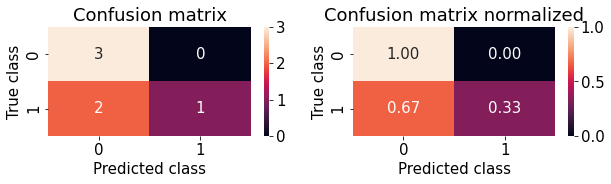

              precision    recall  f1-score   support

           1       0.60      1.00      0.75         3
           2       1.00      0.33      0.50         3

    accuracy                           0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6

                                  0         1  micro-average
accuracy                   0.666667  0.666667       0.666667
precision                  0.600000  1.000000       0.666667
sensitivity                1.000000  0.333333       0.666667
specificity                0.333333  1.000000       0.666667
negative_predictive_value  1.000000  0.600000       0.666667
positive_predictive_value  0.600000  1.000000       0.666667
f1                         0.750000  0.500000       0.666667


In [339]:
conf_matrix(y_test, y_pred)

Test Area under Curve = 0.888888888888889
Train Area under Curve = 0.8875


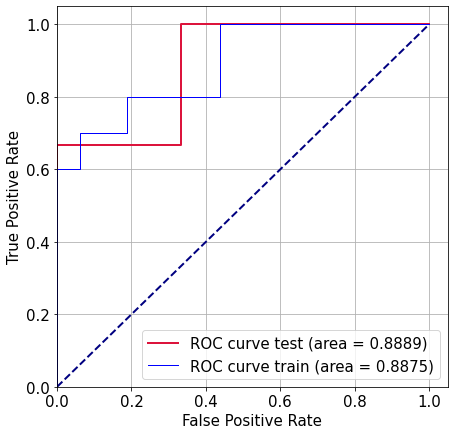

In [340]:
roc_auc_curve(X,X_train,X_test)

In [341]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(classifier, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.792 (0.233)


Ranking de todas en IMGNORM(5) = 'diagnostics_Image-original_Mean', 'original_shape_Flatness', 'original_shape_Sphericity', 'original_firstorder_10Percentile', 'original_firstorder_MeanAbsoluteDeviation'

Ranking de nocorr en IMGNORM(5) = 1-'original_firstorder_Kurtosis'2-'original_gldm_DependenceVariance', 3-'original_shape_Sphericity',4-'original_shape_Elongation',5-'diagnostics_Image-original_Mean' 

el mejor modelo con las IMGnocorr se consigue con 9/11 que son:
['original_glszm_SizeZoneNonUniformity','diagnostics_Image-original_Maximum','original_glrlm_RunLengthNonUniformity','original_glrlm_GrayLevelNonUniformity','diagnostics_Image-original_Mean', 'original_shape_Elongation', 'original_shape_Sphericity', 
        'original_firstorder_Kurtosis', 'original_gldm_DependenceVariance']

con data_norm se consiguen 3 que tienen una cross val de 0.842 (0.219): ['original_shape_MeshVolume', 'original_shape_Sphericity', 'original_glcm_SumEntropy']
con data_nocorrNORM con 3 se consigue mejor cross val 0.850 (0.219)